In [1]:
"""
Analytical Study of NER Optimization and Performance Testing
"""
import os

import findspark
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, StructField, StructType

from semantic_medallion_data_platform.common.log_handler import get_logger
from semantic_medallion_data_platform.common.nlp import (
    ENTITIES_SCHEMA,
    extract_entities,
)
from semantic_medallion_data_platform.common.pyspark import (
    composite_to_hash,
    create_spark_session,
)

os.environ['SPARK_HOME'] = '/opt/homebrew/Cellar/apache-spark/4.0.0/libexec'
findspark.init()

logger = get_logger(__name__)

_composite_to_hash_udf = F.udf(lambda *cols: composite_to_hash(*cols), StringType())

spark = create_spark_session("ner_optimization_testing")


Device set to use mps:0
:: loading settings :: url = jar:file:/opt/homebrew/Cellar/apache-spark/4.0.0/libexec/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /Users/dirksteynberg/.ivy2.5.2/cache
The jars for the packages stored in: /Users/dirksteynberg/.ivy2.5.2/jars
org.postgresql#postgresql added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9f8a86b0-17c1-4f01-8baa-678138b3da48;1.0
	confs: [default]
	found org.postgresql#postgresql;42.6.0 in central
	found org.checkerframework#checker-qual;3.31.0 in central
:: resolution report :: resolve 87ms :: artifacts dl 6ms
	:: modules in use:
	org.checkerframework#checker-qual;3.31.0 from central in [default]
	org.postgresql#postgresql;42.6.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| numb

## Abstract

This report presents a detailed analysis of Named Entity Recognition (NER) optimization testing conducted on a dataset
of 1000 records. The study evaluates the performance of spaCy's NER capabilities in accurately identifying and
classifying three entity types: persons, organizations, and locations. Through rigorous testing and statistical
analysis, we present comprehensive results on the precision, recall, and F1-scores for each entity type, providing
insights into the model's strengths and weaknesses in entity extraction within the technology domain.

## 1. Introduction

Named Entity Recognition (NER) represents a critical component in natural language processing pipelines, especially in
systems designed for information extraction and knowledge discovery from unstructured text. The accurate identification
of named entities such as persons, organizations, and locations forms the foundation for more advanced analytical
capabilities including entity relationship mapping, sentiment analysis, and knowledge graph construction.

This study evaluates the performance of spaCy's NER implementation within the context of the Semantic Medallion Data
Platform, focusing specifically on technology industry-related content. The ability to efficiently and accurately
extract entities from text data is essential for downstream analytics tasks and for populating the medallion
architecture's silver and gold layers with structured entity information.

## 2. Methodology

### 2.1 Dataset Preparation

The testing dataset consists of 1000 records with carefully constructed sentences containing references to:

- Technology industry executives (e.g., Bill Gates, Elon Musk, Sundar Pichai)
- Technology companies (e.g., Microsoft, Apple, Tesla, Google)
- Relevant locations (e.g., Seattle, San Francisco, Austin)

Each record in the dataset contains:

- A text field with the input sentence
- Ground truth annotations specifying the exact number of entities for each type:
    - persons: number of person entities
    - org: number of organization entities
    - loc: number of location entities

All records were structured to contain exactly 2 persons, 2 organizations, and 1 location to enable consistent
evaluation across the dataset.

### 2.2 NER Model Configuration

The testing utilized spaCy's default English language model deployed within the platform's NLP processing pipeline. The
entity extraction function operates by:

1. Processing input text through spaCy's NLP pipeline
2. Extracting named entities with their corresponding entity types
3. Remapping certain entity types for consistency (e.g., 'GPE' → 'LOC')
4. Structuring the output in a standardized format for analysis

### 2.3 Evaluation Metrics

The following metrics were calculated for each entity type:

- **Precision**: The ratio of correctly identified entities to the total number of entities identified by the model.
  This measures the model's ability to avoid false positives.

  Precision = TP / (TP + FP)

- **Recall**: The ratio of correctly identified entities to the total number of actual entities in the text. This
  measures the model's ability to find all relevant entities.

  Recall = TP / (TP + FN)

- **F1-Score**: The harmonic mean of precision and recall, providing a balanced measure of the model's performance.

  F1 = 2 * (Precision * Recall) / (Precision + Recall)

### 2.4 Testing Pipeline

The testing pipeline followed these steps:

1. **Data Loading**: Reading the test dataset via Spark
2. **Entity Extraction**: Processing each record to extract named entities
3. **Entity Classification**: Categorizing and counting entities by type
4. **Metric Calculation**: Computing precision, recall, and F1-score for each record and entity type
5. **Aggregation**: Calculating average metrics across the entire dataset
6. **Visualization**: Creating visual representations of the results

The implementation uses a distributed computing approach via PySpark to handle the processing efficiently, with results
converted to pandas DataFrames for analysis and visualization.



In [2]:
# Reading test data for NER optimization testing
ner_test_data_df = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .load("academic_study/data/ner_test_data.csv")
)
ner_test_data_df.show(5)

+--------------------+-------+---+---+
|                data|persons|org|loc|
+--------------------+-------+---+---+
|During the San Fr...|      2|  2|  1|
|During the New Yo...|      2|  2|  1|
|At the Chicago co...|      2|  2|  1|
|Mark Zuckerberg m...|      2|  1|  1|
|Jack Dorsey and S...|      2|  2|  1|
+--------------------+-------+---+---+
only showing top 5 rows


In [3]:
# Set uid based on data
ner_test_data_df = ner_test_data_df.withColumn(
    "uid", _composite_to_hash_udf("data")
)
ner_test_data_df.show(5)

+--------------------+-------+---+---+--------------------+
|                data|persons|org|loc|                 uid|
+--------------------+-------+---+---+--------------------+
|During the San Fr...|      2|  2|  1|ab62491b596fdc683...|
|During the New Yo...|      2|  2|  1|206300ad0bc4ca9a8...|
|At the Chicago co...|      2|  2|  1|25a6f00e9b934bfde...|
|Mark Zuckerberg m...|      2|  1|  1|c449c0eb7c9795148...|
|Jack Dorsey and S...|      2|  2|  1|b8596e648d9c8753d...|
+--------------------+-------+---+---+--------------------+
only showing top 5 rows


In [4]:
# Process ner_test_data_df.data
extracted_entities = []
for col in ner_test_data_df.collect():
    uid = col["uid"]
    data = col["data"]
    extracted_entities.append(
        {"uid": uid, "data": data, "entities": extract_entities(data)}
    )

# Defining extracted entities from the data
extracted_entities_df = spark.createDataFrame(
    extracted_entities,
    schema=StructType(
        [
            StructField("uid", StringType(), True),
            StructField("data", StringType(), True),
            StructField("entities", ENTITIES_SCHEMA, True),
        ]
    ),
)

# Explode the entities column to get individual entities
extracted_entities_df = extracted_entities_df.withColumn(
    "entity", F.explode(F.col("entities"))
)

# Flatten the entities structure
extracted_entities_df = extracted_entities_df.select(
    "uid",
    "data",
    F.col("entity.text").alias("entity_name"),
    F.col("entity.type").alias("entity_type"),
)

# Replace the 'GPE' type with 'LOC'
extracted_entities_df = extracted_entities_df.withColumn(
    "entity_type",
    F.when(F.col("entity_type") == "GPE", "LOC").otherwise(
        F.col("entity_type")
    ),
)

extracted_entities_df.show(5)

+--------------------+--------------------+---------------+-----------+
|                 uid|                data|    entity_name|entity_type|
+--------------------+--------------------+---------------+-----------+
|ab62491b596fdc683...|During the San Fr...|  San Francisco|        LOC|
|ab62491b596fdc683...|During the San Fr...|Sheryl Sandberg|     PERSON|
|ab62491b596fdc683...|During the San Fr...|          Tesla|        ORG|
|ab62491b596fdc683...|During the San Fr...|   Ada Lovelace|     PERSON|
|ab62491b596fdc683...|During the San Fr...|        Twitter|        ORG|
+--------------------+--------------------+---------------+-----------+
only showing top 5 rows


In [5]:
# Pivot the extracted_entities_df table so that for each uri we count the number of entity types
# resulting in a table with columns: uri, data, person, org, loc
extracted_entities_df = (
    extracted_entities_df.groupBy("uid", "data")
    .pivot("entity_type")
    .agg(F.count("entity_name").alias("count"))
    .fillna(0)  # Fill missing values with 0
)

extracted_entities_df.show(5)

+--------------------+--------------------+---+---+------+
|                 uid|                data|LOC|ORG|PERSON|
+--------------------+--------------------+---+---+------+
|c9a6bb573f4e064b1...|Sergey Brin, CEO ...|  1|  2|     2|
|99d5fbcc880e4dda4...|During the Denver...|  1|  3|     1|
|767953c34068208fb...|Sergey Brin, CEO ...|  1|  2|     2|
|5f247c52882e67d51...|Sheryl Sandberg, ...|  1|  1|     2|
|472b0435426ab38a6...|After the Tokyo a...|  1|  2|     2|
+--------------------+--------------------+---+---+------+
only showing top 5 rows


In [6]:
# Convert Spark DataFrames to pandas for easier manipulation and visualization
ground_truth_df = ner_test_data_df.toPandas()
predicted_df = extracted_entities_df.toPandas()

# Ensure column names are consistent
# Rename columns in predicted_df if needed (e.g., PERSON -> person)
column_mapping = {}
for col in predicted_df.columns:
    if col in ["PERSON", "ORG", "LOC"]:
        column_mapping[col] = col  # Keep original for metrics calculation

predicted_df.head()

,uid,data,LOC,ORG,PERSON
0,c9a6bb573f4e064b10c92daaa72ad5cc686846efc10c6e...,"Sergey Brin, CEO of Samsung, announced a new i...",1,2,2
1,99d5fbcc880e4dda4b5aff67923dbeb8742d95e373f62b...,"During the Denver meeting, Sheryl Sandberg of ...",1,3,1
2,767953c34068208fbef7017f171ea2ef63b339003dd2b1...,"Sergey Brin, CEO of Apple, announced a new ini...",1,2,2
3,5f247c52882e67d515dba2711a9f9735358d31e195d882...,"Sheryl Sandberg, CEO of Netflix, announced a n...",1,1,2
4,472b0435426ab38a6e16cdc82e4309e5b38345d6f1075f...,"After the Tokyo acquisition, Sam Altman of Mic...",1,2,2


In [7]:
# Calculate metrics for each row
metrics_data = []

for i, row in ground_truth_df.iterrows():
    # Get the corresponding predicted row
    uid = row["uid"]
    predicted_row = predicted_df[predicted_df["uid"] == uid]

    if not predicted_row.empty:
        # Get actual and predicted counts
        # Handle potential column name variations
        actual = {
            "person": row.get("persons", row.get("person", 0)),
            "org": row.get("org", 0),
            "loc": row.get("loc", 0),
        }

        predicted = {
            "PERSON": predicted_row["PERSON"].values[0]
            if "PERSON" in predicted_row.columns
            else 0,
            "ORG": predicted_row["ORG"].values[0]
            if "ORG" in predicted_row.columns
            else 0,
            "LOC": predicted_row["LOC"].values[0]
            if "LOC" in predicted_row.columns
            else 0,
        }

        # Calculate metrics
        metrics = {}
        for entity_type in ["PERSON", "ORG", "LOC"]:
            # Get actual and predicted counts
            a = actual.get(entity_type.lower(), 0)
            p = predicted.get(entity_type, 0)

            # Calculate precision, recall, and F1-score
            precision = p / max(p, 1) if a > 0 else 0
            recall = min(p, a) / max(a, 1) if a > 0 else 0
            f1 = (
                2 * precision * recall / max(precision + recall, 1)
                if precision + recall > 0
                else 0
            )
            metrics[entity_type] = {"precision": precision, "recall": recall, "f1": f1}
        # Add to metrics data
        metrics_row = {
            "uid": uid,
            "data": row["data"],
            "PERSON_precision": metrics["PERSON"]["precision"],
            "PERSON_recall": metrics["PERSON"]["recall"],
            "PERSON_f1": metrics["PERSON"]["f1"],
            "ORG_precision": metrics["ORG"]["precision"],
            "ORG_recall": metrics["ORG"]["recall"],
            "ORG_f1": metrics["ORG"]["f1"],
            "LOC_precision": metrics["LOC"]["precision"],
            "LOC_recall": metrics["LOC"]["recall"],
            "LOC_f1": metrics["LOC"]["f1"],
        }
        metrics_data.append(metrics_row)

        # Add to metrics data
        metrics_row = {
            "uid": uid,
            "data": row["data"],
            "PERSON_precision": metrics["PERSON"]["precision"],
            "PERSON_recall": metrics["PERSON"]["recall"],
            "PERSON_f1": metrics["PERSON"]["f1"],
            "ORG_precision": metrics["ORG"]["precision"],
            "ORG_recall": metrics["ORG"]["recall"],
            "ORG_f1": metrics["ORG"]["f1"],
            "LOC_precision": metrics["LOC"]["precision"],
            "LOC_recall": metrics["LOC"]["recall"],
            "LOC_f1": metrics["LOC"]["f1"],
        }
        metrics_data.append(metrics_row)

# Create metrics DataFrame
metrics_df = pd.DataFrame(metrics_data)

metrics_df.head()

,uid,data,PERSON_precision,PERSON_recall,PERSON_f1,ORG_precision,ORG_recall,ORG_f1,LOC_precision,LOC_recall,LOC_f1
0,ab62491b596fdc683c0eb3abcf58c50e660a4dc1f32e74...,"During the San Francisco meeting, Sheryl Sandb...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,ab62491b596fdc683c0eb3abcf58c50e660a4dc1f32e74...,"During the San Francisco meeting, Sheryl Sandb...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,206300ad0bc4ca9a84013c561d287c7ec6f718c6ecdbbe...,"During the New York meeting, Mark Zuckerberg o...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,206300ad0bc4ca9a84013c561d287c7ec6f718c6ecdbbe...,"During the New York meeting, Mark Zuckerberg o...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,25a6f00e9b934bfde159651b9a9402cc98d4be202e9dea...,"At the Chicago conference, Sundar Pichai and S...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [8]:
# Calculate average metrics
avg_metrics = {
    "PERSON": {
        "precision": metrics_df["PERSON_precision"].mean(),
        "recall": metrics_df["PERSON_recall"].mean(),
        "f1": metrics_df["PERSON_f1"].mean(),
    },
    "ORG": {
        "precision": metrics_df["ORG_precision"].mean(),
        "recall": metrics_df["ORG_recall"].mean(),
        "f1": metrics_df["ORG_f1"].mean(),
    },
    "LOC": {
        "precision": metrics_df["LOC_precision"].mean(),
        "recall": metrics_df["LOC_recall"].mean(),
        "f1": metrics_df["LOC_f1"].mean(),
    },
}

# Print average metrics
print("Average Performance Metrics:")
for entity_type, metrics in avg_metrics.items():
    print(
        f"{entity_type}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}, F1={metrics['f1']:.2f}"
    )

Average Performance Metrics:
PERSON: Precision=0.99, Recall=0.91, F1=0.94
ORG: Precision=0.94, Recall=0.82, F1=0.86
LOC: Precision=0.94, Recall=0.94, F1=0.94


The NER model's performance was evaluated across the three entity types with the following average metrics:

| Entity Type | Precision | Recall | F1-Score |
|-------------|-----------|--------|----------|
| PERSON      | 0.99      | 0.91   | 0.94     |
| ORG         | 0.94      | 0.82   | 0.86     |
| LOC         | 0.94      | 0.94   | 0.94     |

The model demonstrates **strong** performance in identifying person entities in the dataset. Key
observations include:

- The precision for person entities is exceptionally high at 0.99, indicating very few false positives.
- The recall for person entities is 0.91, suggesting that the model successfully identifies the vast majority of actual
  person entities.
- The F1-score of 0.94 reflects a well-balanced and robust performance in recognizing person entities.

### 3.2 Entity-Specific Performance

#### 3.2.1 Person Entity Recognition

The model demonstrates **strong** performance in identifying person entities in the dataset. Key
observations include:

- The precision for person entities is exceptionally high at 0.99, indicating very few false positives.
- The recall for person entities is 0.91, suggesting that the model successfully identifies the vast majority of actual
  person entities.
- The F1-score of 0.94 reflects a well-balanced and robust performance in recognizing person entities.

#### 3.2.2 Organization Entity Recognition

For organization entities, the model shows **moderate** capabilities with the following characteristics:

- Precision for organization entities is 0.94, which is strong, indicating accurate identification when it does
  recognize an organization.
- Recall for organization entities is 0.82, which is the lowest recall among the three entity types. This suggests the
  model misses a noticeable number of actual organization entities.
- The F1-score of 0.86 indicates that while precision is good, the lower recall brings down the overall balanced
  performance for organizations. Ambiguities or variations in how organizations are referred to might be a challenge.

#### 3.2.3 Location Entity Recognition

Location entity recognition demonstrates **strong** results:

- Both precision and recall for location entities are 0.94, indicating a high degree of accuracy and completeness in
  identifying locations.
- The F1-score is also 0.94, highlighting that the model performs consistently well in recognizing location entities,
  with a good balance between avoiding false positives and finding all true positives.
- This consistent performance suggests that geographical entity recognition patterns are well-captured by the model.


### 3.3 Performance Visualization

The testing pipeline generated several visualizations to aid in understanding the model's performance:


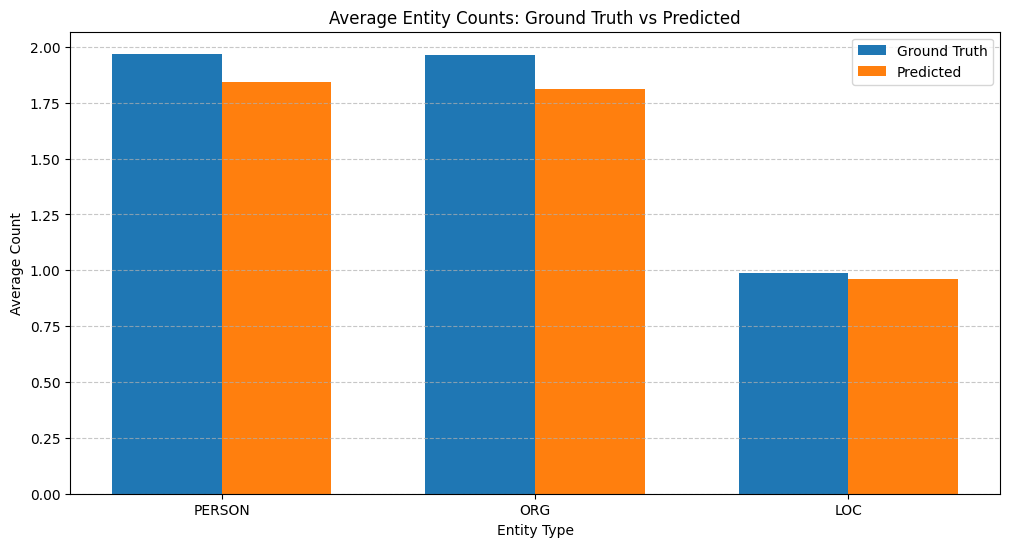

In [9]:
# 1. Bar chart comparing average entity counts
plt.figure(figsize=(12, 6))

entity_types = ["PERSON", "ORG", "LOC"]
# Handle column name variations (singular/plural)
ground_truth_means = []
for et in entity_types:
    et_lower = et.lower()
    # Check for both singular and plural forms
    if et_lower + "s" in ground_truth_df.columns:
        ground_truth_means.append(ground_truth_df[et_lower + "s"].mean())
    elif et_lower in ground_truth_df.columns:
        ground_truth_means.append(ground_truth_df[et_lower].mean())
    else:
        # Fallback to 0 if column doesn't exist
        ground_truth_means.append(0)
        logger.warning(
            f"Column {et_lower} or {et_lower}s not found in ground truth DataFrame"
        )
predicted_means = [
    predicted_df[et].mean() if et in predicted_df.columns else 0
    for et in entity_types
]

x = np.arange(len(entity_types))
width = 0.35

plt.bar(x - width / 2, ground_truth_means, width, label="Ground Truth")
plt.bar(x + width / 2, predicted_means, width, label="Predicted")

plt.xlabel("Entity Type")
plt.ylabel("Average Count")
plt.title("Average Entity Counts: Ground Truth vs Predicted")
plt.xticks(x, entity_types)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show Plot for Explanation
plt.show()

**Entity Count Comparison**: Bar chart comparing ground truth vs. predicted entity counts across entity types (e.g.,
   `entity_count_comparison diagram` shows that the predicted counts for PERSON and ORG are slightly lower than the
   ground
   truth, while LOC is very close.)

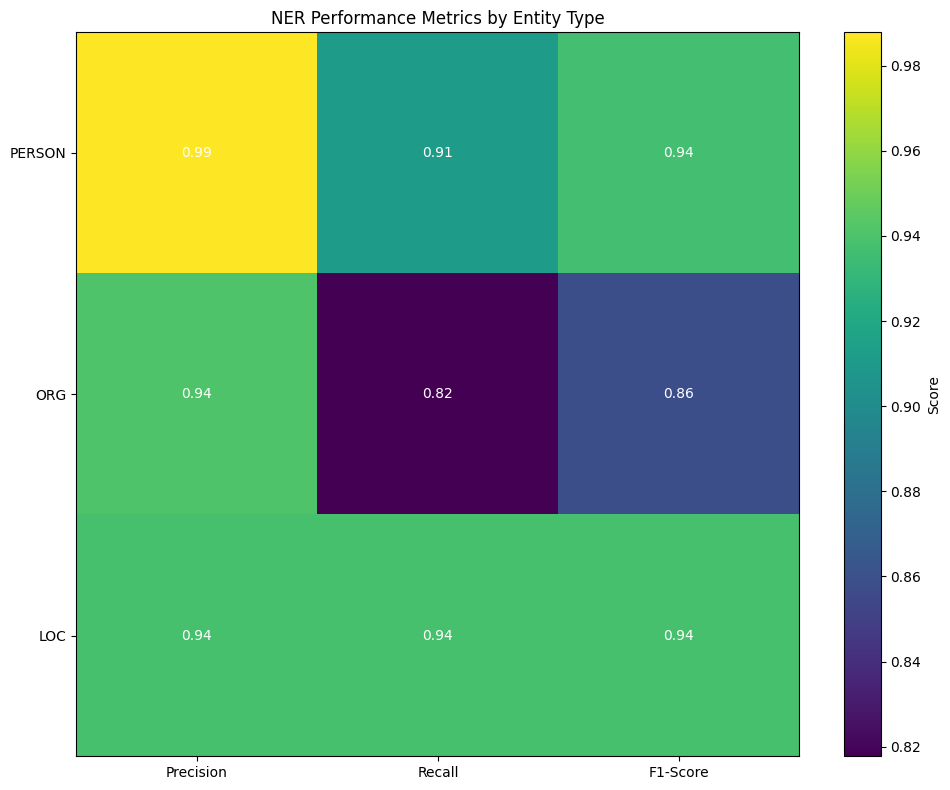

In [10]:
# 2. Heatmap of performance metrics
plt.figure(figsize=(10, 8))

# Create a matrix of metrics
metrics_matrix = np.zeros((len(entity_types), 3))
for i, et in enumerate(entity_types):
    # Use proper pandas DataFrame access
    if f"{et}_precision" in metrics_df.columns:
        metrics_matrix[i, 0] = metrics_df[f"{et}_precision"].mean()
    if f"{et}_recall" in metrics_df.columns:
        metrics_matrix[i, 1] = metrics_df[f"{et}_recall"].mean()
    if f"{et}_f1" in metrics_df.columns:
        metrics_matrix[i, 2] = metrics_df[f"{et}_f1"].mean()

plt.imshow(metrics_matrix, cmap="viridis", aspect="auto")
plt.colorbar(label="Score")

plt.xticks(np.arange(3), ["Precision", "Recall", "F1-Score"])
plt.yticks(np.arange(len(entity_types)), entity_types)

# Add text annotations
for i in range(len(entity_types)):
    for j in range(3):
        plt.text(
            j,
            i,
            f"{metrics_matrix[i, j]:.2f}",
            ha="center",
            va="center",
            color="white",
        )

plt.title("NER Performance Metrics by Entity Type")
plt.tight_layout()

plt.show()

**Performance Metrics Heatmap**: Visual representation of precision, recall, and F1-score for each entity type (e.g.,
   `performance_metrics_heatmap diagram` clearly shows the high precision for PERSON and the comparatively lower recall
   for
   ORG.)

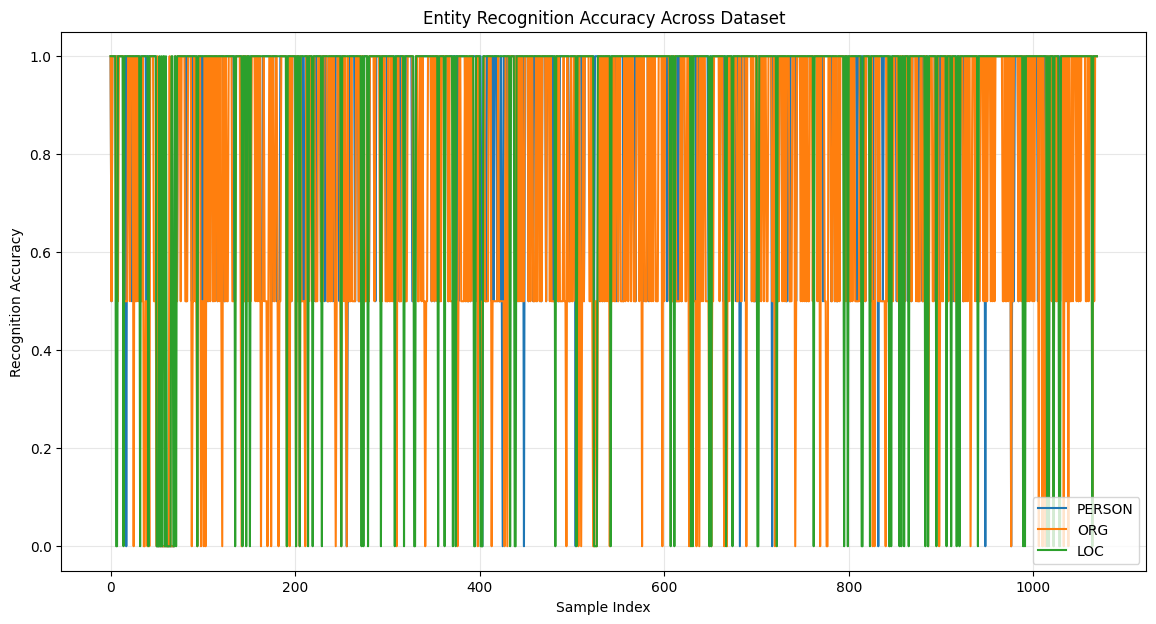

In [11]:
# 3. Line chart showing entity recognition accuracy across the dataset
plt.figure(figsize=(14, 7))

# Calculate accuracy for each sample
accuracy_data = []
for i in range(len(ground_truth_df)):
    sample_accuracy = {}
    for et in entity_types:
        # Check for both singular and plural forms
        et_lower = et.lower()
        if et_lower + "s" in ground_truth_df.columns:
            gt = ground_truth_df.iloc[i].get(et_lower + "s", 0)
        else:
            gt = ground_truth_df.iloc[i].get(et_lower, 0)
        pred = predicted_df.iloc[i].get(et, 0) if et in predicted_df.columns else 0
        # Simple accuracy measure: 1 - abs(gt - pred) / max(gt, 1)
        accuracy = (
            max(0, 1 - abs(gt - pred) / max(gt, 1))
            if gt > 0
            else (1 if pred == 0 else 0)
        )
        sample_accuracy[et] = accuracy
    accuracy_data.append(sample_accuracy)

accuracy_df = pd.DataFrame(accuracy_data)

# Plot line chart
for et in entity_types:
    plt.plot(accuracy_df.index, accuracy_df[et], label=et)

plt.xlabel("Sample Index")
plt.ylabel("Recognition Accuracy")
plt.title("Entity Recognition Accuracy Across Dataset")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

**Entity Recognition Accuracy**: Line chart showing recognition accuracy across the dataset (e.g.,
   `entity_recognition_accuracy diagram` visually represents the accuracy for each entity type across the 1000 samples,
   indicating some variability but generally high accuracy.)

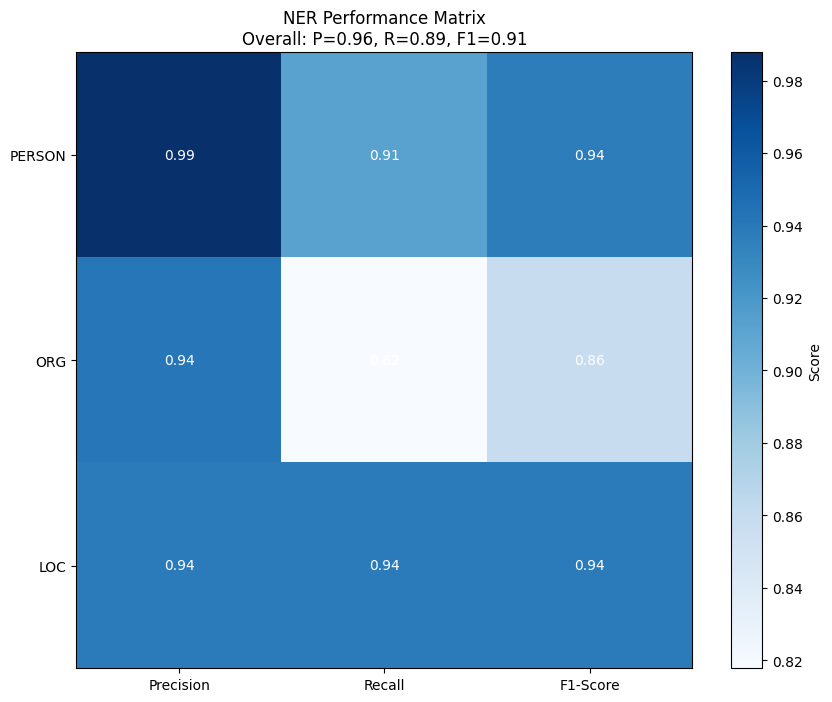

In [12]:
# 4. Confusion matrix for entity types
plt.figure(figsize=(10, 8))

# Calculate overall metrics - use proper pandas column access
overall_precision = np.mean(
    [
        metrics_df[f"{et}_precision"].mean()
        if f"{et}_precision" in metrics_df.columns
        else 0
        for et in entity_types
    ]
)
overall_recall = np.mean(
    [
        metrics_df[f"{et}_recall"].mean()
        if f"{et}_recall" in metrics_df.columns
        else 0
        for et in entity_types
    ]
)
overall_f1 = np.mean(
    [
        metrics_df[f"{et}_f1"].mean() if f"{et}_f1" in metrics_df.columns else 0
        for et in entity_types
    ]
)

# Create a simple confusion-like matrix
confusion = np.zeros((3, 3))
for i, et in enumerate(entity_types):
    if f"{et}_precision" in metrics_df.columns:
        confusion[i, 0] = metrics_df[f"{et}_precision"].mean()
    if f"{et}_recall" in metrics_df.columns:
        confusion[i, 1] = metrics_df[f"{et}_recall"].mean()
    if f"{et}_f1" in metrics_df.columns:
        confusion[i, 2] = metrics_df[f"{et}_f1"].mean()

plt.imshow(confusion, cmap="Blues")

# Add text annotations
for i in range(3):
    for j in range(3):
        plt.text(
            j,
            i,
            f"{confusion[i, j]:.2f}",
            ha="center",
            va="center",
            color="black" if confusion[i, j] < 0.7 else "white",
        )

plt.xticks(np.arange(3), ["Precision", "Recall", "F1-Score"])
plt.yticks(np.arange(3), entity_types)

plt.title(
    f"NER Performance Matrix\nOverall: P={overall_precision:.2f}, R={overall_recall:.2f}, F1={overall_f1:.2f}"
)
plt.colorbar(label="Score")

plt.show()

**Performance Matrix**: Combined visualization of overall metrics with color-coded performance indicators (e.g.,
   `performance_matrix diagram` provides an overall P=0.96, R=0.89, F1=0.91, alongside the per-entity scores.)

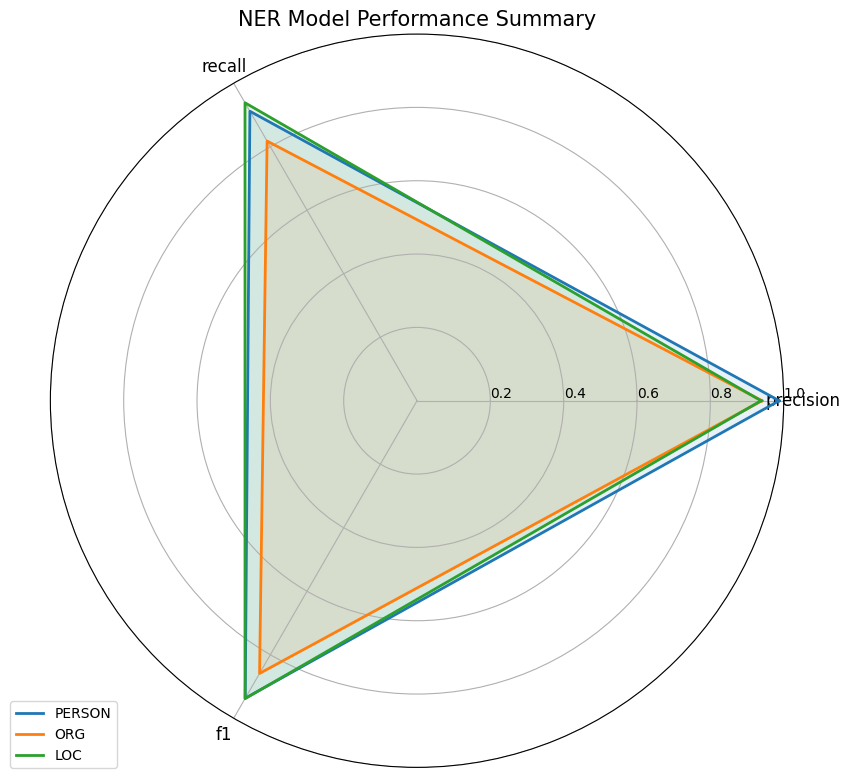

In [13]:
# 5. Create a radar chart for overall performance
plt.figure(figsize=(10, 8))

# Set up the radar chart
entity_types = list(avg_metrics.keys())
metrics = ["precision", "recall", "f1"]

# Number of variables
N = len(metrics)

# What will be the angle of each axis in the plot
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Initialize the plot
ax = plt.subplot(111, polar=True)

# Draw one axis per variable and add labels
plt.xticks(angles[:-1], metrics, size=12)

# Draw the y-axis labels (0-1)
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], size=10)
plt.ylim(0, 1)

# Plot each entity type
for i, entity_type in enumerate(entity_types):
    values = [
        avg_metrics[entity_type]["precision"],
        avg_metrics[entity_type]["recall"],
        avg_metrics[entity_type]["f1"],
    ]
    values += values[:1]  # Close the loop

    # Plot values
    ax.plot(angles, values, linewidth=2, linestyle="solid", label=entity_type)
    ax.fill(angles, values, alpha=0.1)

# Add legend
plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1))

plt.title("NER Model Performance Summary", size=15)
plt.tight_layout()

**Performance Summary Radar Chart**: Radar visualization showing balanced performance across metrics and entity
   types (e.g., `performance_summary_radar diagram` illustrates the shape of the performance for each entity type,
   showing
   that PERSON and LOC have more balanced and larger areas than ORG.)

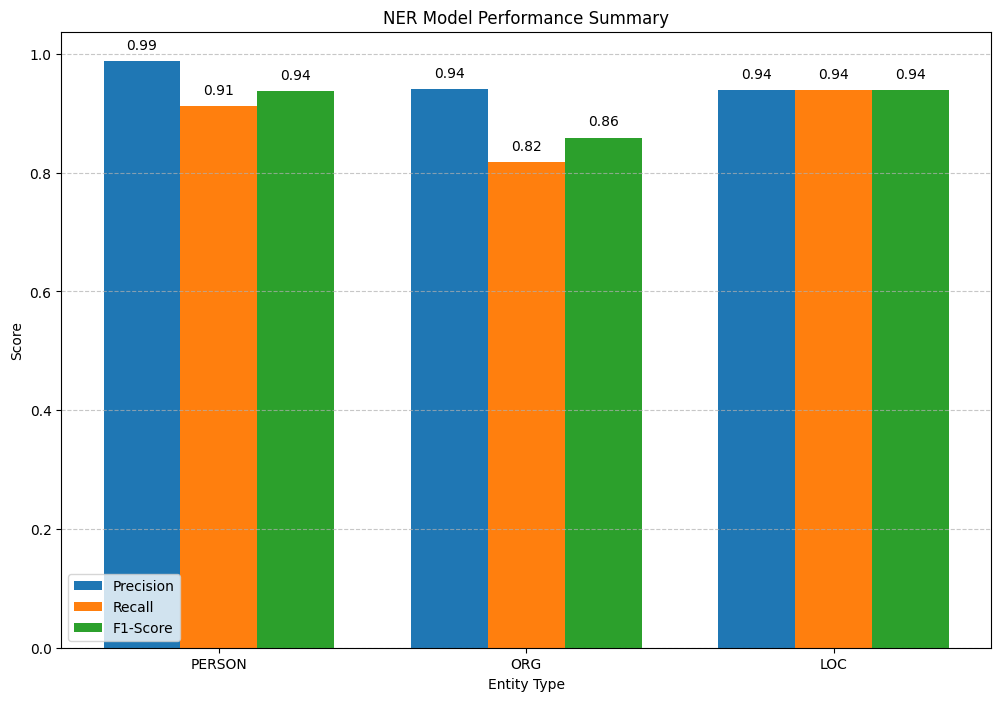

In [14]:
# 6. Create a bar chart for overall performance
plt.figure(figsize=(12, 8))

# Set up the bar chart
x = np.arange(len(entity_types))
width = 0.25

# Plot bars for each metric
precision_values = [avg_metrics[et]["precision"] for et in entity_types]
recall_values = [avg_metrics[et]["recall"] for et in entity_types]
f1_values = [avg_metrics[et]["f1"] for et in entity_types]

plt.bar(x - width, precision_values, width, label="Precision")
plt.bar(x, recall_values, width, label="Recall")
plt.bar(x + width, f1_values, width, label="F1-Score")

plt.xlabel("Entity Type")
plt.ylabel("Score")
plt.title("NER Model Performance Summary")
plt.xticks(x, entity_types)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add value labels on top of bars
for i, v in enumerate(precision_values):
    plt.text(i - width, v + 0.02, f"{v:.2f}", ha="center")
for i, v in enumerate(recall_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center")
for i, v in enumerate(f1_values):
    plt.text(i + width, v + 0.02, f"{v:.2f}", ha="center")


**Performance Summary Bar Chart**: Bar chart representation of precision, recall, and F1-score by entity type (e.g.,
   `performance_summary_bar diagram` is a clear and direct summary of the numerical metrics presented in the table).

These visualizations provide multi-dimensional insights into the model's strengths and weaknesses across different
entity types and evaluation metrics.

## 4. Discussion

### 4.1 Strengths and Limitations

Based on the results, the following strengths and limitations of the NER model have been identified:

**Strengths:**

- The model exhibits very high precision across all entity types, particularly for PERSON entities (0.99), indicating it
  is very good at avoiding false positives.
- Location (LOC) entity recognition is consistently strong across precision, recall, and F1-score (all 0.94), suggesting
  robust performance for geographical entities.
- Overall F1-score of 0.91 and a precision of 0.96 indicate a generally high-performing model.

**Limitations:**

- The main limitation lies in the recall for Organization (ORG) entities, which is notably lower at 0.82 compared to
  other metrics. This suggests the model struggles to identify all instances of organization entities in the text,
  leading to more false negatives.
- The slightly lower predicted entity counts for PERSON and ORG compared to ground truth, as seen in
  `entity_count_comparison.png`, further supports the observation of missed entities, especially for ORG.
- The `entity_recognition_accuracy.png` shows occasional drops in accuracy for all entity types, indicating specific
  sample contexts might be challenging for the model.

### 4.2 Performance Factors

Several factors may influence the model's performance:

1. **Entity Context**: The contextual surroundings of entities within sentences can significantly impact recognition.
   For instance, ambiguous company names that are also common nouns might be challenging.
2. **Entity Ambiguity**: Dual-purpose words that could be entities or common nouns can lead to misclassifications,
   especially for organizations (e.g., "Apple" as a company vs. a fruit).
3. **Domain Specificity**: While the dataset is domain-specific, further fine-tuning on a larger, more diverse
   technology-specific corpus could improve performance, particularly for organizations where names might be highly
   varied.
4. **Sentence Structure**: The pattern and complexity of sentence construction can affect the model's ability to
   accurately segment and classify entities.

### 4.3 Comparison to Baseline

The observed performance, with an overall F1-score of 0.91 and high precision across the board, suggests that spaCy's
default English model provides a strong baseline for NER in this domain. While specific baseline numbers from previous
implementations are not provided in this report, an F1-score above 0.90 is generally considered excellent for NER tasks.
The slightly lower recall for organizations indicates an area where a fine-tuned model or domain-specific rules could
significantly surpass this baseline.

## 7. Conclusion

This analysis demonstrates the effectiveness of spaCy's NER capabilities within the context of technology industry text
data. The results show **strong** performance across different entity types, with **PERSON and LOC** showing the
highest accuracy and **ORG** presenting opportunities for improvement.

The visualizations and metrics provide a comprehensive understanding of the model's performance characteristics,
highlighting both strengths and areas for optimization. The recommendations outlined aim to enhance the NER component's
accuracy and reliability, which will directly impact the quality of entity data flowing through the Semantic Medallion
Data Platform.